# Job Scoring Calculation using Neo4j and Python

This notebook guides you through calculating a comprehensive job matching score based on semantic similarity from a Neo4j graph database, focusing specifically on one resume (`community_id=801`).

---

## 📌 Step 1: Setup Neo4j Connection in Python

First, establish a connection from your notebook to the Neo4j database.

### Python code:



In [3]:

from neo4j import GraphDatabase
import pandas as pd

# Connect to Neo4j
uri = "neo4j://20.14.162.151:7687"  # Replace with your Neo4j instance URI
username = "neo4j"              # Your username
password = "recluse2025"      # Your password

driver = GraphDatabase.driver(uri, auth=(username, password))

# Function to run Cypher query
def run_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters)
        return pd.DataFrame(result.data())


## 📌 Step 2: Select a resume form a trait cluster

For this experiment, we will select a STEM-heavy cluster

In [4]:
query_resume = """
MATCH (r:Resume)
WHERE r.community_id = 801
RETURN r.id AS resume_id, r.original_job AS original_job, r.community_id AS community_id, r.community_label AS community_label,
r.resume_text AS resume_text
"""
resume_df = run_query(query_resume)
display(resume_df)


,resume_id,original_job,community_id,community_label,resume_text
0,426f2186-c78b-4a2d-81df-c8307ace8747,Java Developer,801,STEM-heavy,TECHNICAL STRENGTHS Computer Language Java / J...


In [18]:
from sentence_transformers import SentenceTransformer
import numpy as np
model_name = "all-mpnet-base-v2" 
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [19]:
#get the 

from textblob import TextBlob

# Assuming resume_df already has the data
resume_text = resume_df.iloc[0]['resume_text']
print("Resume Text:\n", resume_text)


Resume Text:
 TECHNICAL STRENGTHS Computer Language Java / J2EE, Swift, HTML, Shell script, MySQL Databases MySQL Tools SVN, Jenkins, Hudson, Weblogic12c Software Android Studio, Eclipse, Oracle, Xcode Operating Systems Win 10, Mac ( High Sierra ) Education Details June 2016 B. E. Information Technology Goregaon, MAHARASHTRA, IN Vidyalankar Institute of Technology May 2013 Mumbai, Maharashtra Thakur Polytechnic May 2010 Mumbai, Maharashtra St. John's Universal School Java developer Java developer - Tech Mahindra Skill Details JAVA- Exprience - 21 months MYSQL- Exprience - 21 months DATABASES- Exprience - 17 months J2EE- Exprience - 17 months ANDROID- Exprience - 6 monthsCompany Details company - Tech Mahindra description - Team Size: 5 Environment: Java, Mysql, Shell script. Webserver: Jenkins. Description: OR-Formatter is an application which takes the input file as Geneva Modified File GMF from Geneva server and reads the data to generate Bill backup and Bill Invoices for Client cust

In [20]:
blob = TextBlob(resume_text)

# Inspecting basic information
print(f"Text length: {len(blob.words)} words")
print(f"Sentences count: {len(blob.sentences)}")


Text length: 345 words
Sentences count: 20


In [21]:
noun_phrases = blob.noun_phrases
print(f"Noun phrases found ({len(noun_phrases)}):\n")
for np in noun_phrases:
    print("-", np)


Noun phrases found (104):

- technical strengths computer language java
- j2ee
- swift
- html
- shell
- mysql databases mysql tools svn
- jenkins
- hudson
- weblogic12c software android
- eclipse
- oracle
- xcode
- systems win
- mac
- sierra
- details june
- b. e. information
- goregaon
- maharashtra
- in vidyalankar
- may
- mumbai
- maharashtra thakur
- may
- mumbai
- maharashtra
- john
- universal
- java
- java
- tech mahindra skill details java- exprience
- mysql- exprience
- databases- exprience
- j2ee- exprience
- android- exprience
- details
- tech mahindra
- team size
- environment
- java
- mysql
- shell
- webserver
- jenkins
- description
- or-formatter
- input file
- geneva modified file gmf
- geneva
- bill
- bill invoices
- client
- bt
- played
- java
- current modules
- worked
- requirement analysis
- user stories
- dev unit
- user stories
- handled e2e
- prepare
- program level
- user-level documentation
- tech mahindra
- team size
- environment
- java ejb
- mysql
- shell
-

In [30]:
noun_phrases.index("team size")

37

In [23]:
# Define the query to retrieve entities from Neo4j
query_entities = """
MATCH (entity)
WHERE entity:Knowledge OR entity:Abilities OR entity:Skills OR entity:Work_activities
RETURN labels(entity)[0] AS entity_type, entity.text AS entity_text
ORDER BY entity_type, entity_text
"""

# Execute the query
entities_df = run_query(query_entities)


In [24]:
# Create embeddings for each noun phrase
noun_phrase_embeddings = [model.encode(np) for np in noun_phrases]

# Create DataFrame
nounphrase_df = pd.DataFrame({
    'noun_phrase': noun_phrases,
    'embedding': noun_phrase_embeddings
})
nounphrase_df.head()

,noun_phrase,embedding
0,technical strengths computer language java,"[-0.0045953733, -0.051126696, -0.04391737, -0...."
1,j2ee,"[0.02439166, 0.06157444, 0.026841352, -0.01565..."
2,swift,"[0.035363823, -0.010278737, -0.021040538, -0.0..."
3,html,"[0.02712843, -0.024502028, -0.009735838, -0.00..."
4,shell,"[-0.01905843, -0.06412493, -0.018446606, 0.009..."


In [25]:
display(entities_df.head(20))

,entity_type,entity_text
0,Abilities,Category Flexibility
1,Abilities,Dynamic Flexibility
2,Abilities,Dynamic Strength
3,Abilities,Explosive Strength
4,Abilities,Extent Flexibility
5,Abilities,Fluency of Ideas
6,Abilities,Memorization
7,Abilities,Multilimb Coordination
8,Abilities,Number Facility
9,Abilities,Oral Expression


In [26]:
nounphrase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   noun_phrase  104 non-null    object
 1   embedding    104 non-null    object
dtypes: object(2)
memory usage: 1.8+ KB


In [27]:


# Generate embeddings and add as a new column
entities_df['entity_embeddings'] = entities_df['entity_text'].apply(lambda x: model.encode(x))

# Verify results
display(entities_df.head())


,entity_type,entity_text,entity_embeddings
0,Abilities,Category Flexibility,"[0.05120196, 0.09744891, -0.0618364, -0.022522..."
1,Abilities,Dynamic Flexibility,"[0.026132064, 0.01646614, -0.044300795, -0.049..."
2,Abilities,Dynamic Strength,"[-0.029631265, -0.058616195, -0.026912851, -0...."
3,Abilities,Explosive Strength,"[-0.01992141, -0.017855039, 0.03263288, -0.017..."
4,Abilities,Extent Flexibility,"[-0.0036472701, -0.02147115, -0.023691023, -0...."


In [29]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Convert embeddings lists to numpy arrays for efficient computation
entity_embeddings = np.vstack(entities_df['entity_embeddings'].values)
nounphrase_embeddings = np.vstack(nounphrase_df['embedding'].values)

# Calculate cosine similarity (noun_phrases vs. entities)
similarity_matrix = cosine_similarity(nounphrase_embeddings, entity_embeddings)

# Prepare a DataFrame of matches above the 0.65 threshold
results = []

for np_idx, noun_phrase in enumerate(nounphrase_df['noun_phrase']):
    for ent_idx, entity_text in enumerate(entities_df['entity_text']):
        similarity_score = similarity_matrix[np_idx, ent_idx]
        if similarity_score > 0.65:
            results.append({
                'noun_phrase': noun_phrase,
                'entity_text': entity_text,
                'entity_type': entities_df.iloc[ent_idx]['entity_type'],
                'similarity_score': similarity_score
            })

# Create the final results DataFrame
similarity_df = pd.DataFrame(results)

# Display the top matches
display(similarity_df)


,noun_phrase,entity_text,entity_type,similarity_score
0,java,Programming,Skills,0.702846
1,java,Programming,Skills,0.702846
2,team size,Developing and Building Teams,Work_activities,0.657865
3,java,Programming,Skills,0.702846
4,java,Programming,Skills,0.702846
5,team size,Developing and Building Teams,Work_activities,0.657865
6,java,Programming,Skills,0.702846
7,java,Programming,Skills,0.702846


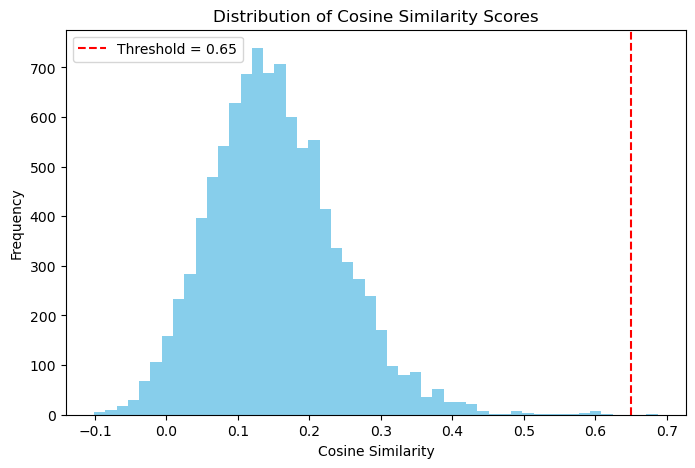

In [17]:
import matplotlib.pyplot as plt

# Flatten the similarity scores to visualize
all_scores = similarity_matrix.flatten()

# Plot histogram to visualize similarity distribution
plt.figure(figsize=(8,5))
plt.hist(all_scores, bins=50, color='skyblue')
plt.title("Distribution of Cosine Similarity Scores")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.axvline(x=0.65, color='red', linestyle='--', label='Threshold = 0.65')
plt.legend()
plt.show()


## 📌 Step 3: Calculate Individual Entity Scores per Job Title

Calculate individual entity scores (score_k(j)) for each job based on your similarity threshold (≥ 0.65).



In [7]:
entity_score_query = """
MATCH (r:Resume {community_id: 801})-[:CONTAINS]->(:NounPhrase)-[sim:SIMILAR_TO]->(entity)-[req:REQUIRED_FOR]->(job:JobTitle)
WITH job.title AS Job, labels(entity)[0] AS entity_type, sum(sim.score * req.importance) AS entity_score
ORDER BY Job, entity_type
RETURN Job, entity_type, entity_score
"""

entity_scores_df = run_query(entity_score_query)
display(entity_scores_df.head(10))  # Display first few rows


KeyboardInterrupt: 

In [10]:
import os
import pandas as pd
import logging
from neo4j import GraphDatabase

# ------------------------------------------
# Neo4j connection settings
# ------------------------------------------
NEO4J_URI = "bolt://20.14.162.151:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "recluse2025"

input_dir = "../data/similarity_outputs"
resume_csv_path = "../data/annotations_scenario_1/cleaned_resumes.csv"

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

# ------------------------------------------
# Step 1: Clear the Neo4j database
# ------------------------------------------

def delete_all_nodes(tx):
    tx.run("MATCH (n) DETACH DELETE n")

def drop_constraints(tx):
    for record in tx.run("SHOW CONSTRAINTS").data():
        tx.run(f"DROP CONSTRAINT {record['name']}")

def drop_indexes(tx):
    for record in tx.run("SHOW INDEXES").data():
        tx.run(f"DROP INDEX {record['name']}")

def clear_database():
    with driver.session() as session:
        logging.info("🧹 Deleting all nodes and relationships...")
        session.execute_write(delete_all_nodes)
    with driver.session() as session:
        logging.info("🧹 Dropping all constraints...")
        session.execute_write(drop_constraints)
    with driver.session() as session:
        logging.info("🧹 Dropping all indexes...")
        session.execute_write(drop_indexes)
    logging.info("✅ Neo4j fully cleared.")

# ------------------------------------------
# Step 2: Create constraints dynamically
# ------------------------------------------

def create_constraints(tx, entity_labels):
    tx.run("CREATE CONSTRAINT IF NOT EXISTS FOR (r:Resume) REQUIRE r.id IS UNIQUE")
    tx.run("CREATE CONSTRAINT IF NOT EXISTS FOR (n:NounPhrase) REQUIRE n.text IS UNIQUE")
    tx.run("CREATE CONSTRAINT IF NOT EXISTS FOR (j:JobTitle) REQUIRE j.title IS UNIQUE")
    for label in entity_labels:
        tx.run(f"CREATE CONSTRAINT IF NOT EXISTS FOR (e:{label}) REQUIRE e.text IS UNIQUE")
        tx.run(f"CREATE INDEX IF NOT EXISTS FOR (e:{label}) ON (e.onetsoc_code)")

# ------------------------------------------
# Step 3: Load resume CSV and create Resume nodes
# ------------------------------------------

def load_resumes_from_csv():
    df = pd.read_csv(resume_csv_path)
    return df[["resume_id", "resume_text", "original_job"]].drop_duplicates()

def push_resume_node(tx, resume_id, resume_text, original_job):
    tx.run("""
        MERGE (r:Resume {id: $resume_id})
        SET r.resume_text = $resume_text,
            r.original_job = $original_job
    """, resume_id=resume_id, resume_text=resume_text, original_job=original_job)

# ------------------------------------------
# Step 4: Push similarity data and build graph
# ------------------------------------------

def push_to_neo4j(tx, record, entity_label, entity_key):
    query = f"""
        MATCH (r:Resume {{id: $resume_id}})
        MERGE (n:NounPhrase {{text: $noun_phrase}})
        MERGE (e:{entity_label} {{text: $entity_text}})
        MERGE (j:JobTitle {{title: $job_title}})
        SET j.onetsoc_code = $onetsoc_code
        MERGE (r)-[:CONTAINS]->(n)
        MERGE (n)-[s:SIMILAR_TO]->(e)
        SET s.score = $similarity_score
        {'SET s.example_text = $example_text' if entity_label in ['Tools', 'Tech'] else ''}
        MERGE (e)-[rj:REQUIRED_FOR]->(j)
        SET rj.importance = $data_value
    """

    params = {
        "resume_id": record["resume_id"],
        "noun_phrase": record["noun_phrase"],
        "entity_text": record[entity_key],
        "job_title": record["entity_job_title"],
        "similarity_score": round(record["similarity_score"], 4),
        "data_value": record["data_value"],
        "onetsoc_code": record["onetsoc_code"]
    }

    if entity_label in ["Tools", "Tech"]:
        params["example_text"] = record["example_text"]

    tx.run(query, **params)

# ------------------------------------------
# Step 5: Main execution
# ------------------------------------------

def main():
    # Reset the database
    clear_database()

    #resume_abilities_similarity_matrix.csv  resume_skills_similarity_matrix.csv           similarity_matrix_tech.csv
    #resume_knowledge_similarity_matrix.csv  resume_work_activities_similarity_matrix.csv  similarity_matrix_tools.csv

    # Define fixed entity labels and expected files
    entity_files = {
        "Abilities": "resume_abilities_similarity_matrix.csv ",
        "Knowledge": "resume_knowledge_similarity_matrix.csv",
        "Skills": "resume_skills_similarity_matrix.csv ",
        "Workactivities": "resume_work_activities_similarity_matrix.csv",
        "Tools": "similarity_matrix_tools.csv",
        "Tech": "similarity_matrix_tech.csv"
    }

    entity_labels = list(entity_files.keys())

    # Create constraints
    with driver.session() as session:
        session.execute_write(create_constraints, entity_labels)
        logging.info(f"✅ Constraints created for: {entity_labels}")

    # Create Resume nodes
    df_resumes = load_resumes_from_csv()
    with driver.session() as session:
        for _, row in df_resumes.iterrows():
            session.execute_write(push_resume_node, row["resume_id"], row["resume_text"], row["original_job"])
    logging.info(f"✅ Created {len(df_resumes)} Resume nodes.")

    # Load similarity CSVs and build graph
    with driver.session() as session:
        for label, file in entity_files.items():
            file_path = os.path.join(input_dir, file)
            if not os.path.exists(file_path):
                logging.warning(f"⚠️ File not found: {file_path}, skipping.")
                continue

            logging.info(f"📂 Loading: {file_path}")
            df = pd.read_csv(file_path)

            entity_key = f"{label.lower()}_entity"
            required_cols = [
                "resume_id", "noun_phrase", entity_key,
                "similarity_score", "data_value", "entity_job_title", "onetsoc_code"
            ]

            if label in ["Tools", "Tech"]:
                required_cols.append("example_text")

            if not all(col in df.columns for col in required_cols):
                logging.warning(f"⚠️ Required columns missing in {file}, skipping.")
                continue

            for _, row in df.iterrows():
                session.execute_write(push_to_neo4j, row, label, entity_key)

            logging.info(f"✅ Finished pushing {label} data.")

    driver.close()
    logging.info("🎉 All graph data pushed successfully to Neo4j.")



In [ ]:
# ------------------------------------------
# Run the script
# ------------------------------------------
if __name__ == "__main__":
    main()


In [11]:
    # Define fixed entity labels and expected files
entity_files = {
        "Abilities": "resume_abilities_similarity_matrix.csv ",
        "Knowledge": "resume_knowledge_similarity_matrix.csv",
        "Skills": "resume_skills_similarity_matrix.csv ",
        "Workactivities": "resume_work_activities_similarity_matrix.csv",
        "Tools": "similarity_matrix_tools.csv",
        "Tech": "similarity_matrix_tech.csv"
    }

entity_labels = list(entity_files.keys())

In [12]:
entity_labels

['Abilities', 'Knowledge', 'Skills', 'Workactivities', 'Tools', 'Tech']

In [20]:
for label, file in entity_files.items():
    file_path = os.path.join(input_dir, file)
    print(file_path)

../data/similarity_outputs/resume_abilities_similarity_matrix.csv 
../data/similarity_outputs/resume_knowledge_similarity_matrix.csv
../data/similarity_outputs/resume_skills_similarity_matrix.csv 
../data/similarity_outputs/resume_work_activities_similarity_matrix.csv
../data/similarity_outputs/similarity_matrix_tools.csv
../data/similarity_outputs/similarity_matrix_tech.csv


In [22]:
df = pd.read_csv("../data/similarity_outputs/resume_abilities_similarity_matrix.csv")

In [23]:
os.path.exists(file_path)

True